# Paper and pencil

The following paper & pencil questions are meant to check your comprehension of the lecture and prior math knowledge with regards to neural networks. Please review the lecture and reading material if you find that you're unable to answer these questions.

* What is the difference between a deep and a shallow neural network?
* List the building blocks of a fully connected neural network (also called multilayer perceptron).
* What is the role of the activation function in a neural network?
* A neural network has a number of paramters: the number of layers and nodes per layer, the choice of activation function, weight matrices, bias terms, etc. Which of these are optimized during training of the network?
* What is the difference between regression and classification?
* Compute the derivative of the generic function $f(x,w) = (h(w x + b) - l)^2$ with respect to $w,b$ and $x$ using the chain rule. This function models a very simple neural network with a single neuron and depends on the scalar variables $w, b, x$ and scalar constant $l$. Think about how you would compute gradients with respect to $w,b,x$ if all variables are no longer scalars but vectors. 

# 0 Prelude

In [92]:
%matplotlib inline 
%config InlineBackend.figure_format='retina'

import numpy as np
import scipy
import scipy.special
import collections

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams['figure.figsize'] = (21.0, 6.0)

# Overview 
Machine learning, deep neural networks and AI have an increasing impact not only on science but also our daily life. Prime examples are natural language translation in our mobile phones, emerging autonomous driving, and medicine.
In this exercise, we apply neural networks to the domain of fashion to identify clothing articles purely from product photographs. One example use case would be to filter out falsely listed shirts when searching for a dress in an online store.

In this homework, you will get to build a complete Deep Learning toolchain: Specifically, you will

1. Prepare a dataset of example images and corresponding labels
2. Construct a neural network consisting of affine and non-linear layers
3. Write a solver to optimize the NN parameters
4. Train the NN and choose a suitable network architecture.
$\newcommand{\X}{\mathbf{x}}$
$\newcommand{\XA}{\mathbf{x1}}$
$\newcommand{\XB}{\mathbf{x2}}$
$\newcommand{\iA}{\mathbf{i1}}$
$\newcommand{\iB}{\mathbf{i2}}$
$\newcommand{\J}{\mathbf{J}}$
$\newcommand{\Y}{\mathbf{y}}$
$\newcommand{\W}{\mathbf{W}}$
$\newcommand{\w}{\mathbf{w}}$
$\newcommand{\A}{\mathbf{a}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\affine}{\texttt{affine}}$
$\newcommand{\identity}{\texttt{identity}}$
$\newcommand{\relu}{\texttt{relu}}$
$\newcommand{\sigmoid}{\texttt{sigmoid}}$
$%The Matrix Cookbook is a good source to refresh vector and matrix calculus and to lookup rules for gradient computation, Chapter 2, Derivatives [2].
%[2] K. B. Petersen and M. S. Pedersen https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf$

# 1 Dataset preparation (10 Points)

Fashion-MNIST is a huge dataset of images from Zalando (https://github.com/zalandoresearch/fashion-mnist). It provides thousands of example images and for each image a corresponding label of the article class.  Download a copy of this dataset by clicking <a href="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/data.zip">here</a> and unzip the contents so that they are located in a subdirecory ``data`` relative to the Jupyter notebook file.

In the following, we load a training and test set, each with thousands of examples. The training set is used for optimizing the parameters of the NN. The test set is used to test how well the model generalizes to unseen images. Such a strictly separated test set is very important. A simple algorithm could perform a nearest neighbor search to figure out if a query image was present during training. That algorithm would be perfect on the training set, but NN search does not generalize well to new images. The fundamental goal of AI, and of this exercise, is to develop algorithms that learn a pattern from past experiences (**training**) that is general enough to be applicable to new situations (**testing**).

The training and test set each contains a list of images and a list of associated labels. The labels are integers in the range ``[0,..,9]`` but each integer corresponds to a semantic class, e.g. ``0:'T-shirt/top',1:'Trouser'``. We provide the following functions to load and display lists of images and corresponding labels. Execute the provided code to inspect examples.

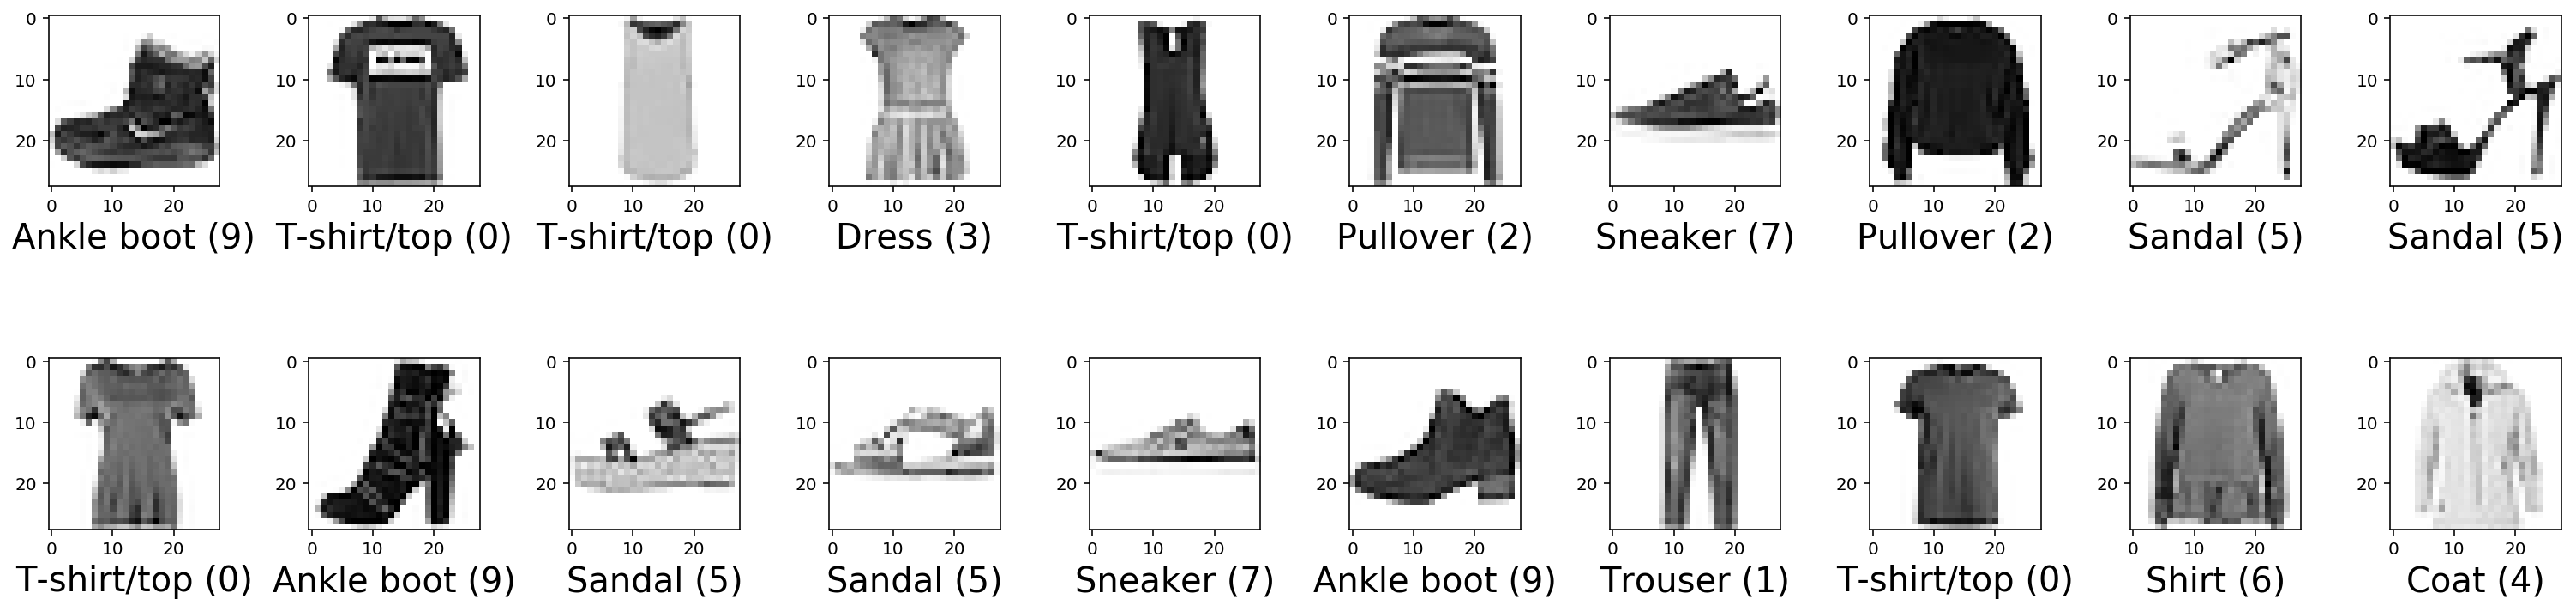

Label assignment:  {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [93]:
fashion_train = np.load('data/mnist_fashion_train.npz')
fashion_test = np.load('data/mnist_fashion_test.npz')

label_names = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag', 9:'Ankle boot'}

# Plots a list of images and corresponding labels
def plot_items(images,labels=None,gt_labels=None):
    num_images = len(images)
    images_per_row = 10
    num_rows = np.ceil(num_images / images_per_row)
    for i,image in enumerate(images):
        # create subfigure for image
        ax = plt.subplot(num_rows,images_per_row,i+1)
        plt.imshow(image, cmap='Greys', interpolation='None')
        # show label name
        if labels is not None:
            plt.xlabel("{} ({})".format(label_names[labels[i]], labels[i]),fontsize=20)
        # indicate correct or false prediction with a green or red border
        if gt_labels is not None:
            rect = patches.Rectangle((0,0),27,27,linewidth=3,edgecolor='g' if labels[i]==gt_labels[i] else 'r',facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout() # remove some unnecessary space between images
    plt.show()

plot_items(fashion_train['images'][:20], fashion_train['labels'])
print('Label assignment: ',label_names)

#### What can we observe in the above output? 

Images are grayscale, have 28x28 pixels, are randomly ordered and are assigned to ten classes named

0. Tshirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

You may be wondering why the images have such low resolution. This is an intentional choice on our part to make the classification problem tractable with relatively simple neural networks. For higher-resolution images convolutional neural networks with a very deep architecture would be required, which is beyond the scope of this homework exercise. Yet, the principles we develop in this exercise generalize to such models and higher resolutions. 

In a first step, we will inspect the statistics of the dataset and prepare it for machine learning.

**TODO:** First, compute and plot the mean image across the fashion training dataset. Note that the mean images have the same dimension as a single image and ``fashion_train['images']`` have shape ``(50000, 28, 28)``. Think about the dimension along which you apply ``np.mean``. Throughout this whole exercise, type your solution in the provided field right below the task discription.

(28, 28)


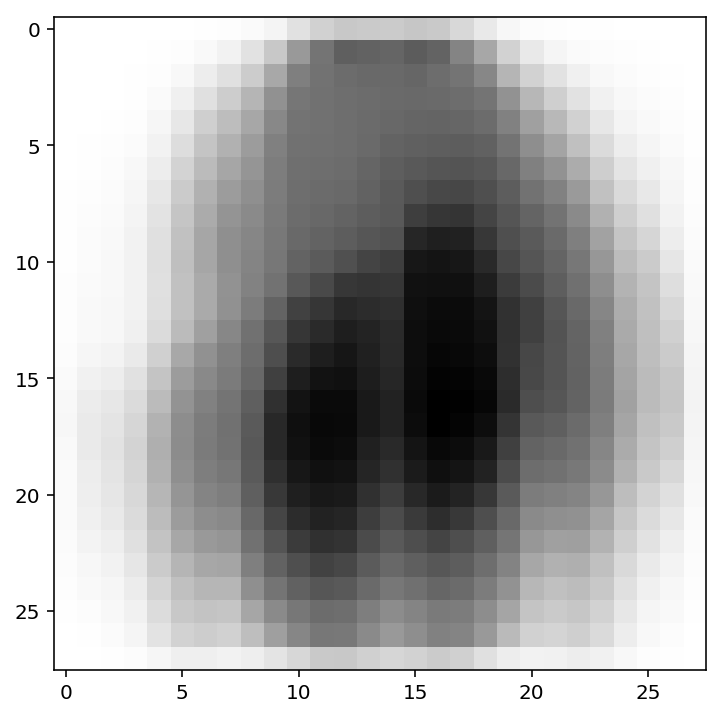

In [94]:
# solution

mean_image = np.mean(fashion_train['images'], axis=0)

print(mean_image.shape)
plt.imshow(mean_image, cmap='Greys', interpolation='None')

**TODO:** That mean image is not very expressive. Compute  class-specific means for all classes: for instance, the mean pullover image would only consider images with ``fashion_train['labels']==8``.
Plot the class-specific mean images together with their labels using the function ``plot_items`` provided above. Inspect the first code block of this exercise to learn about the arguments of ``plot_items``.

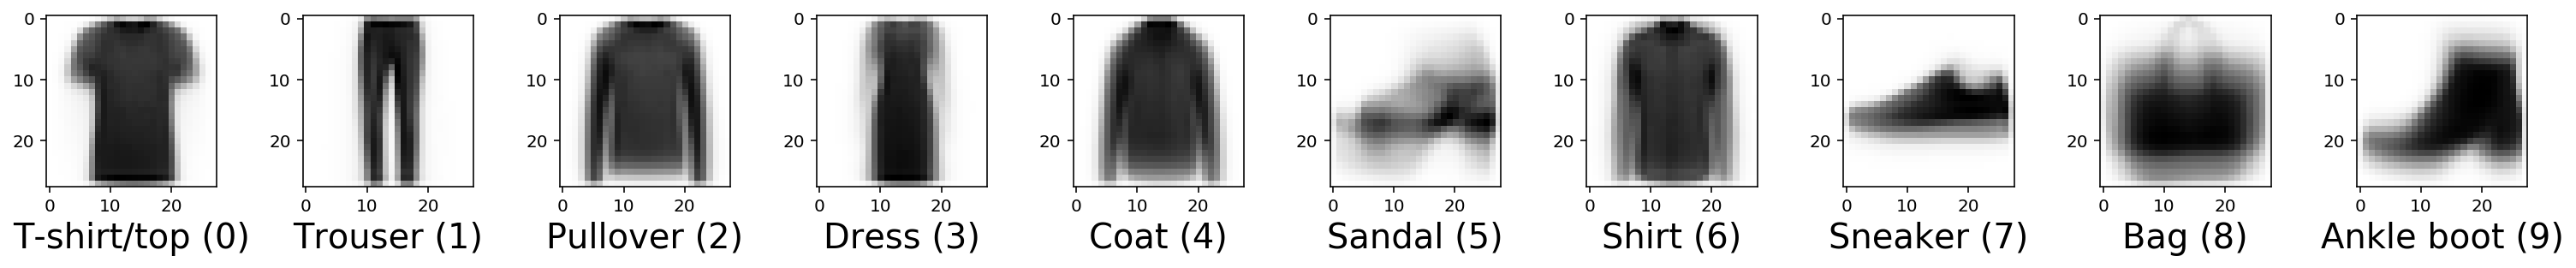

In [95]:
# solution
final_means = np.empty([10,28,28])

for i in range(10):
    temp = fashion_train['images'][(fashion_train['labels']==i)]
    temp2 = np.mean(temp, axis = 0)
    final_means[i]=temp2
    
labels_number = np.arange(10)
plot_items(final_means, labels_number)


That looks more interesting. Observe the agreement of the mean shapes with their semantic labels. This is partly due to the fact that all objects are oriented upright and are centered. Such centering is a common preprocessing step and eases the learning task. The mean shoe looks quite different from the mean top, hence these will be easy to distinguish. However, determining the right shoe class (sandal, sneaker, boot) and top class (top, pullover, coat, shirt) will be more difficult.

Neural networks are composed of interchangeable building blocks, including the network architecture, activation function, and initial weights. Choosing the right components for a given problem can be hard. By normalizing the input and output, these choices are less sensitive to the specific task. We will follow the common practice and normalize the standard deviation of all input variables to one and the mean to zero. This process is called **whitening transformation**.

**TODO:** To be able to normalize the fashion dataset, compute the mean pixel value and its standard deviation of the training set. Note that opposed to the previous task we are not interested in the mean image, but the mean value across all pixels (i.e. a scalar value).

In [96]:
# solution
length = len(fashion_train['images'])

fashion_mean = np.mean(fashion_train['images'])
fashion_std = np.std(fashion_train['images'])

print('fashion_mean = ',fashion_mean,'fashion_std = ',fashion_std)

fashion_mean =  72.8022218622 fashion_std =  89.960030211


We use these values in the following to normalize the training and test images by subtracting the mean and dividing by the standard deviation. Furthermore, we limit the number of examples to 10k by default, to reduce execution time.

In [97]:
def fashion_prepare_regression(dataset, max_iterations=10000):
    return {'images': (dataset['images'][:max_iterations] - fashion_mean) / fashion_std,
            'labels':  dataset['labels'][:max_iterations]}

fashion_train_regression    = fashion_prepare_regression(fashion_train)
fashion_test_regression = fashion_prepare_regression(fashion_test)

Having defined our training and test sets using proper data normalization, we are ready to implement and deploy deep learning.

# 2 Constructing a fully connected artificial neural network

Our goal is to construct a **fully connected network** consisting of $n$ hidden layers. Each layer consists of several artificial neurons which apply non-linear activation functions on the output of the preceding layer, as sketched in the following graph. This overal approach is inspired by the behavior of real neurons in biological organisms, albeit with significant simplifications.

<br><img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/neuralnetwork_noderep_simple_cut.png"><br>

Networks become more powerful the more layers and neurons per layer are used. Each additional neuron als increases the number of parameters that must be optimized, and larger networks easily have on the order of thousands or even millions of parameters. In such cases, performance becomes an important concern. Luckily, nodes within a layer can be executed in parallel. Pay attention to use numpy vector and array operations as often as possible to avoid inefficient for-loop constructs.To gain full points, vectorized solutions are mandatory. 

## 2.1 Activation Units (10 points)

We construct the NN bottom up, from the activation function of single neurons, over layers, to the composition of the complete network. Activation functions are at the core of a NN. Without them every NN (no matter how deep) would collapse to a simple linear function, which is not powerful. Instead, we want to be able to use the NN to approximate a complex non-linear function that will allow us to accomplish our goal of classifying clothing articles.

**TODO:** Define a function ``relu(x)`` that takes a vector ``X`` as input and returns the element-wise RELU activation. Make use of ``np.maximum`` in its implementation. Also define the function ``identity(x)`` that maps ``x`` to ``x``.

For comparison, we already provide the sigmoid activation function.

In [98]:
# solution
def relu(x):
    return np.maximum(x, 0)

def identity(x):
    return np.array(x)

def sigmoid(x):
    return scipy.special.expit(x)


**Verify:** ``relu([-1,0,1]) == [0,0,1]`` and ``identity([-1,0,1]) == [-1,0,1]``

In [99]:
print('relu([-1,0,1]) =', relu([-1,0,1]))
print('identity([-1,0,1]) =', identity([-1,0,1]))
print('test:', relu([-1,0,1]) == [0,0,1], identity([-1,0,1]) == [-1,0,1])

relu([-1,0,1]) = [0 0 1]
identity([-1,0,1]) = [-1  0  1]
test: [ True  True  True] [ True  True  True]


**TODO:** To gain a feeling for the behaviour of the different activation functions, plot ``relu(x)``, ``identity(x)`` and ``sigmoid(x)`` for the range ``x`` $\in [-5,5]$ using ``plt``. Constrain the output range to ``(-1, 1)`` using ``plt.ylim``.

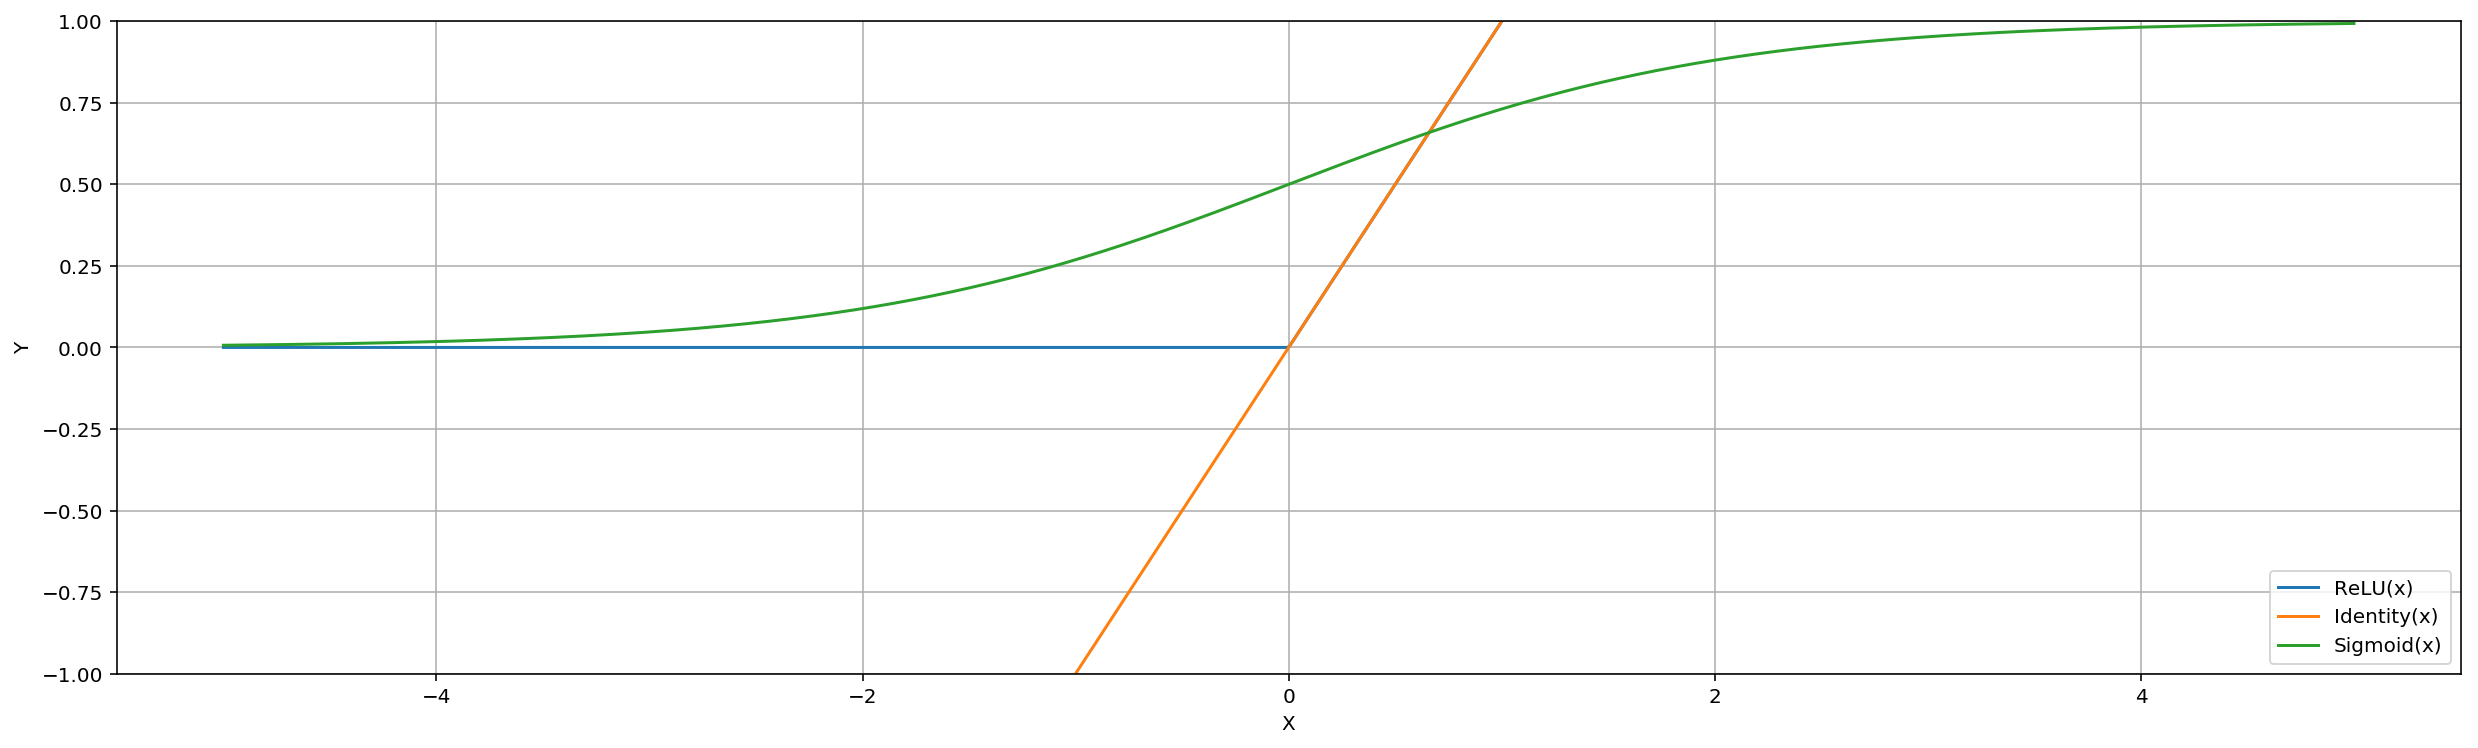

In [100]:
# solution
x = np.linspace(-5, 5, 1000)
plt.ylim([-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

plt.plot(x, relu(x), label="ReLU(x)")
plt.plot(x, identity(x), label="Identity(x)")
plt.plot(x, sigmoid(x), label="Sigmoid(x)")
plt.legend(loc="lower right")

plt.show()

## 2.2 A single neuron (10 points)

In this task, we implement the most common artificial neuron representation. It computes the dot product of the input vector $\X$ with a weight vector $\mathbf{w}$ and applies the non-linear activation function $h$, as sketched below.

<img width="200" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/neuralnetwork_single_neuron.png">

**TODO:** Implement the transformation of a single neuron ``neuron(x,w,h)``, where ``x`` and ``w`` are numpy vectors and ``h`` is a function, e.g. ``h=relu``. Recall that a neuron computes $\sum_{i=1}^{m} \X_i \w_i + \w_{m+1}$  for input ``x`` of length $m$. Implement this affine expression as a single dot product by appending an additional constant element of value 1 to ``x`` (as explained during the lecture). 

In [101]:
# solution
def neuron(x, w, h):
    return h(np.dot(np.append(x, 1), w))


**Validate:** Test your function on $\X = [-1,0,1]$, $\mathbf{w} = [1,2,3,4]$, and $\texttt{h=relu}$. The output should be 6.

In [102]:
x_test = [-1, 0, 1]
w_test = [1, 2, 3, 4]
out = neuron(x_test, w_test, h=relu)
print('out = ',out, 'test:', out == 6)

out =  6 test: True


## 2.3 Network definition (15 points)

The goal is to construct a fully connected neural network function nn($\X$, weights, activation_functions) that maps input $\X \in \R^{m_0}$ to prediction $\Y \in \R^{m_n}$ through $n$ layers of width $m_i$ and activation functions $h_i$, with $i \in (1,2,\dots,n)$. As sketched below for a network with a single hidden layer.

<img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/neuralnetwork_noderep.png">

Representing each neuron separately is complex and computationally inefficient. It is more practical to group neurons into layers and to represent each layer as vectorized function. The following sketch shows the simplification.

<img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/neuralnetwork_layerrep.png">

The output $\A^{(i)}$ of layer $i$ is a vector of length $m_{i}$, the list of all outputs of individual neurons in that layer.
The output $\A^{(i-1)}$ of layer $i-1$ is the input to layer $i$.
Each neuron of layer $i$ takes the same input values, although it will generally apply different weights and bias terms.
The weighting for each of the $m_i$ neurons can thus be expressed as a single matrix multiplication $\W^{(i)} \A^{(i-1)}$, where $\W^{(i)}$ has shape $[m_n, m_{n-1}+1]$ and represents all weights of layer $i$.
Note that $\W^{(i)}$ has one dimension more than $m_{i-1}$ to represent the bias term.

**TODO:** Create a weight matrix ``W1`` filled with the value ``1`` for a layer with a single input and 5 outputs, and a second weight matrix ``W2`` (also filled with ``1``) for a layer with 5 inputs and a single output.

In [103]:
# solution
W1 = np.ones((5, 2))
W2 = np.ones((1, 6))

**Validate:** Verify that the matrix shapes are correct. The output of the tested matrix multiplication should be (5, 6).

In [104]:
print('W1:',W1.shape,'W2:',W2.shape)
print('test:', (W1[:,:-1] @ W2).shape == (5,6) )

W1: (5, 2) W2: (1, 6)
test: True


The activation functions have been designed to accept vector input. To build a complete network, we must still handle the affine transformation and to chain affine and non-linear operations together.

**TODO:** Implement ``affine(``$\X$, $\W\!\!$ ``)`` that computes the affine transformation of a vector $\X \in \R^{m_{i-1}}$ to a vector $\R^{m_i}$. This works analogously to the single neuron implementation by extending $\X'$ with an additional constant entry of value ``1`` to model the bias term.

**Hint:** Make sure that you use NumPy operations and use the ``@`` operator for matrix multiplication.

In [105]:
# solution
def affine(x, W):
    return (W @ np.append(x, 1))

**Verify:** ``affine(np.array([-1,0,0.5,1,1.5]), W2) == np.array([3])``

In [106]:
out = affine([-1,0,0.5,1,1.5], W2)
print('out =',out, 'test:', out == np.array([3]))

out = [ 3.] test: [ True]


**TODO:** Complete the following implementation of ``nn(x, [``$\W^{(1)},\W^{(2)},\dots,\W^{(n)}$ ``], [``$h^{(1)},h^{(2)},\dots,h^{(n)}$ ``])``. Given the input ``x``, it shall compute the complete forward pass of the network. Besides the input, it takes a list of weight matrixes, where each element $\W^{(i)}$ is the weight matrix of layer $i$, and a list of corresponding non-linear activation functions $h^{(i)}$, one function for each layer. The provided loop iterates over all layers, starting at the first hidden layer and selects $\W^{(i)}$ and $h^{(i)}$. It iterates $n$ times for lists of $n$ weight matrices. Call ``affine(x, W)`` and ``h(x)`` in the right order and return the final network output. The previously shown network graphic provides a good reference.

In [107]:
# solution
def nn(x, W_list, h_list):
    assert len(W_list) == len(h_list)
    for W,h in zip(W_list, h_list):
        x = h(affine(x, W))
    return x

**Verify:** The following code creates a network architecture with weights ``[W1, W2]`` and relu activation function (``h_list=[relu,identity]``). Is ``output == [array([ 1.]), array([ 6.]), array([ 11.])]``?

In [108]:
network_A = lambda x: nn(x, [W1,W2], [relu, identity])
out1 = network_A(np.array([-1]))
out2 = network_A(np.array([0]))
out3 = network_A(np.array([1]))
print("Output:", out1, out2, out3)
print("Verify:", out1==np.array([1]), out2==np.array([6]), out3==np.array([11]))

Output: [ 1.] [ 6.] [ 11.]
Verify: [ True] [ True] [ True]


Congratulations. You've just built all the code that is needed to evaluate a neural network!
However, an untrained network without sensible weights is not particularly useful. 

# 3 Training a NN

We will use the simple yet efficient iterative gradient descent optimization to find the network parameters (Section 3.5).
This requires finding a good starting point (Section 3.1 Network initialization), as well as the objective function with respect to the parameters (Section 3.4 Backpropagation).

Gradients in turn require the ability to compute Jacobians of the intermediate steps (Section 3.2 Layer-wise Jacobian matrices) and gradients of the loss functions (Section 3.3 Objective function).

## 3.1 Network initialization (10 points)

Note that random initialization of the network weights is crucial. For instance, setting all weights to a constant value would create the same function and gradient at each node of a layer, forcing a whole layer to behave like a single neuron under gradient-based optimization.
Assigning all weights from the uniform distribution between zero and one is also problematic. The mean and variance of the output would grow with the number of hidden layers and neurons.

We provide the ``initialize_network(network_shape)`` function that takes a list of layer widths ``network_shape =  ``$\ [m_0,m_1,\dots,m_n]$ and outputs corresponding weight matrices $[\W^{(1)},\dots,\W^{(n)}]$ with dimensions as introduced before. It inserts the extra dimension for the bias term and initializes it to zero. NumPy's random number generator is deterministically initialized using ``np.random.seed`` so that you will always get the same initialization.

**TODO:** Implement the function ``random_matrix(rows,columns)`` that takes the number of rows and columns as input and returns a matrix ``W`` of that shape. The elements of ``W``  shall be random, drawn from the uniform distribution across the range $[-\sqrt{\frac{3}{m}}, \sqrt{\frac{3}{m}}]$, where $m$ is the number of columns. This choice addresses the problems mentioned above.

*Hint*: ``np.random.uniform`` may be useful.

In [109]:
# solution
def random_matrix(rows, columns):
    return np.random.uniform(- np.sqrt(3/columns), np.sqrt(3/columns), np.array([rows, columns]))

In [110]:
# provided
def initialize_network(network_shape):
    np.random.seed(0)
    W_list = [random_matrix(network_shape[i], network_shape[i-1]) 
              for i in range(1, len(network_shape))]
    Wb_list = [np.concatenate([W,np.zeros([W.shape[0],1])], axis=1) for W in W_list]
    return Wb_list

**Verify:** Is your weight initialization correct? The following code computes the mean and standard deviation of a network with a single hidden layer. ``mean`` should be roughly zero and ``std`` roughly one. A relative error of 10% is tolerable.

In [111]:
random_output = nn(x=np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(1000)), 
                           W_list=initialize_network([1000,1000,1000]),
                           h_list=[identity, identity])
print("mean = {}, std = {}".format(np.mean(random_output), np.std(random_output)))

mean = -0.01963003292991268, std = 1.0315894356692794


**Verify:** Is the dimension of the following output equal to 2?

In [112]:
network_simple = lambda x: nn(x, initialize_network([1,5,3,2]), [relu, relu, identity])
out = network_simple(np.array([10]))
print("out =", out, 'test: ', out.shape == (2,))

out = [ 4.30790412 -0.25846403] test:  True


# Hacker Points (optional, 5 points)

The factor $\sqrt{\frac{3}{m}}$ used for initialization seems arbitrary. Why does that specific value preserve a mean of zero and standard deviation of 1? 

**TODO:** Inspect the propagation of variances through the network. Let $\text{var}(\w_1 \X_1 + \dots + \w_n \X_n)$ be the variance of the output of a neuron with identity activation and bias equal to 0, where $\w$ is the weight vector of the neuron and $\X$ the input vector. First, derive the variance of $\w_i$ that is necessary to make $\text{var}(\w_1 \X_1, \dots, \w_n \X_n)$ equal to one, assuming that all $\X_i$ have variance one. Second, infer why $\w_i$ should be initialized uniformly at random between $-\sqrt{\frac{3}{m}}$ and $\sqrt{\frac{3}{m}}$.

**Hint:** You can use $\text{var}(x+y) = \text{var}(x)+\text{var}(y)$, $\text{var}(x y) = \text{var}(x) \text{var}(y)$ (if x,y are independent and have zero mean, which can be assumed here), and $\text{var}(\text{uniform}(-a,a)) = \frac{1}{3} a^2$.

In [113]:
# solution

## 3.2 Layer-wise Jacobian matrices (15 points)

Our deep neural network has universal approximation capabilities. It remains to find a good set of parameters to unleash its computational power. We will use (stochastic-) gradient descent and the backpropagation algorithm to compute gradients.

To apply the backpropagation algorithm we need to know the derivative of our objective. Since our NN-functions are multivariate it means that we need to derive the Jacobian matrices of all intermediate steps. Recall that the Jacobi matrix of $f$ with respect to $\X$ is defined as

$$
{\displaystyle J^f_\X
=\frac{\partial f}{\partial \X}
={\begin{bmatrix}{\dfrac {\partial f_{1}}{\partial \X_{1}}}&\cdots &{\dfrac {\partial f_{1}}{\partial \X_{n}}}\\\vdots &\ddots &\vdots \\{\dfrac {\partial f_{m}}{\partial \X_{1}}}&\cdots &{\dfrac {\partial f_{m}}{\partial \X_{n}}}\end{bmatrix}}},
$$

where $f_i$ is the i'th output of function $f$, $\X_j$ is the j'th element of the input $\X$, and $\dfrac {\partial f_{i}}{\partial \X_{j}}$ the partial derivative of $f_i$ with respect to $\X_j$. For a function $h$ that performs element wise operations the Jacobian is of diagonal form:

<img width="200" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_h_x.png">

**TODO:** Define functions that compute the Jacobian matrices $\J^{\relu}_\X$ and 
$\J^{\identity}_\X$of the vectorized relu and identity functions, respectively. We provide the Jacobian of the sigmoid function as a hint.

In [114]:
# solution
def d_relu_d_x(x):
    x[x<=0]=0
    x[x>0]=1
    return np.diag(x)

def d_identity_d_x(x):
    return np.eye(len(x))

def d_sigmoid_d_x(x): 
    # computes sigmoid(x)*(1-sigmoid(x))
    sx = sigmoid(x)
    return np.diag(sx * (1.0 - sx))

**Verify:** Test your implementations on the vector ``x = [-1,0,2]``. Is the output a vector or a matrix, of square or non-square shape?

In [115]:
test_x = np.array([-1,0,2])
print("d_relu_d_x =\n{}".format(d_relu_d_x(test_x)))
print("d_identity_d_x =\n{}".format(d_identity_d_x(test_x)))
print("d_sigmoid_d_x =\n{}".format(d_sigmoid_d_x(test_x)))

d_relu_d_x =
[[0 0 0]
 [0 0 0]
 [0 0 1]]
d_identity_d_x =
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
d_sigmoid_d_x =
[[ 0.25        0.          0.        ]
 [ 0.          0.25        0.        ]
 [ 0.          0.          0.19661193]]


#### Solutions
The output of the computation are square diagonal matrices

The Jacobian matrix of the $\affine$ function is more intricate since it has two arguments. It must be differentiated with respect to both $\mathbf{x}$ and $\W$. As discussed in the lecture, the shape of $\J^{\affine}_\X$ is dense. The following image sketches the Jacobian matrix of ``affine(``$\mathbf{x},\W^{(2)}$ ``) `` with respect to $\mathbf{x}$:

<img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_w_x.png">

**TODO:** Define $\J^{\affine}_\X$, i.e. the Jacobian of ``affine(``$\mathbf{x},\W^{(2)}$ ``) `` with respect to ``x``. Respect that ``W`` models the linear term and the bias term which is independent of ``x``.

In [116]:
# solution
def d_affine_d_x(W):
    return W[:, :-1]

**Verify:** Are your dimensions correct for the application on $\X = [-1,0,2]$, $\W = [[1,-2,-3,-4],[-5,-6,7,8]]$? The right output is $\texttt{d_affine_d_x = [[1 -2 -3],[-5 -6 7]]}$.

In [117]:
W = np.array([[1,-2,-3,-4],[-5,-6,7,8]])
d_W =  d_affine_d_x(W)
d_W_correct = np.array([[1,-2,-3],[-5,-6,7]])
print("d_W =\n{}\nd_W_correct =\n{}\ntest: {}".format(d_W, d_W_correct, d_W==d_W_correct))

d_W =
[[ 1 -2 -3]
 [-5 -6  7]]
d_W_correct =
[[ 1 -2 -3]
 [-5 -6  7]]
test: [[ True  True  True]
 [ True  True  True]]


How can one possibly compute the Jacobian of multidimensional function with respect to a matrix $\W$? Is it a tensor?
To simplify the matter we reshape $\W$ into a vector (also called **flattening**) and construct the Jacobi matrix $\J^{\affine}_\W(\mathbf{x},\W)$ as before. We compute the derivative of the outputs of $\affine$ with respect to all elements of $\W$.  

We provide you with the implementation for this step. Since the $i$th output is defined by row $i$ of ``W`` and is independent of rows $j \neq i$ the Jacobian matrix has diagonal structure. Since each row of $\W$ is multiplied by $\X$ (ordinary matrix multiplication of $\W \X$), $\X$ is replicated in the diagonal, e.g. for $\W^{(1)}$:
<img width="400" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_w_w.png">
This diagonal structure can be constructed efficiently using a <a href="https://en.wikipedia.org/wiki/Kronecker_product">Kronecker product</a>:

In [118]:
def d_affine_d_W(x, W):
    num_outputs = W.shape[0]
    num_weights_per_node = W.shape[1]
    x_homogen = np.append(x,[1])
    return np.kron(np.eye(num_outputs), x_homogen)

## 3.3 Objective function (10 points)

The last missing ingredient is to define and differentiate the objective function so that it can be minimized using gradient descent. Our goal is to predict the class of garment shown in the input image. We would like to penalize if the network predicts wrong labels. We chose the objective function $E_i = \|nn(\X_i,[\W^{(1)},\W^{(2)},\dots]) - \Y_i\|^2$.

Its goal is to estimate the difference between prediction $nn(\X_i,[\W^{(1)},\W^{(2)},\dots])$ and class label $\Y_i$, for all input-label pairs $(\X_i,\Y_i)$ in the training set. Note, that we use the $l_2$ norm as a loss (squared loss). It is efficient to compute and everywhere differentiable. 
For instance, the network can be trained to output the bag label 8 when executed on a bag image by penalizing every other prediction quadratically:

<img width="500" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/objectivefunction.png">

Later, we will use a network that outputs multiple labels, i.e. outputs a vector, which requires the norm notation $\| \cdot \|$ above. It simply means that we take sum of the squared differences of all output and label elements, $l_2(\X,\Y) = \|\X - \Y\|^2 = \sum_j (\X[j] - \Y[j])^2$, where $[j]$ acesses the j'th element. 

**TODO:** Implement the $l_2$ loss function ``l2(x,y)``. It shall take vectorized input and compute the sum over the squared differences of the prediction and the labels (element-wise).

**TODO:** Second, derive and implement the function ``d_l2_d_x(x,y)`` that computes the Jacobian $\nabla_\X \, l_2(\X,\Y) = \frac{\partial l_2}{\partial \X}$. Recall that the elements of $\frac{\partial l_2(\X,\Y)}{\partial \X}$ are the partial derivatives of ``l2(x,y)`` with respect to the individual elements of $\X$.

**Hint:** The output of the loss is always a scalar, this implies that the Jacobian is a $1\times m_i$ matrix (row vector), where $m_i$ is the length of ``x``. It may be esier to first derive the scalar form (``x`` and ``y`` beeing np.arrays with a single element) and to subsequently extend it to handle vectorized input. We test both cases below.

In [119]:
# solution
def l2(x,y):
    return np.round(np.linalg.norm(x-y)**2)

def d_l2_d_x(x,y):
    return np.array([2*np.subtract(x,y)])

**Verify:** Test that both, the scalar and the vectorized case, pass.

In [120]:
x = np.array([1])
y = np.array([2])
scalar_l2 = l2(x,y)
scalar_d_l2 = d_l2_d_x(x,y)
print('scalar_l2:',scalar_l2)
print('scalar_d_l2:',scalar_d_l2)
print('test value:',scalar_l2==1,'and',scalar_d_l2==np.array([[-2]]))
print('test 2D shape:',scalar_d_l2.shape==(1, 1),'\n')

x = np.array([-1,0,1])
y = np.array([1,1,2])
vector_l2 = l2(x,y)
vector_d_l2 = d_l2_d_x(x, y)
print('vector_l2:',vector_l2)
print('vector_d_l2:',vector_d_l2)
print('test value:',vector_l2==6,'and', vector_d_l2==np.array([[-4,-2,-2]]))
print('test 2D shape:',vector_d_l2.shape==(1, 3))

scalar_l2: 1.0
scalar_d_l2: [[-2]]
test value: True and [[ True]]
test 2D shape: True 

vector_l2: 6.0
vector_d_l2: [[-4 -2 -2]]
test value: True and [[ True  True  True]]
test 2D shape: True


## 3.4 Backpropagation

<div class="alert alert-block alert-info">
Note: Section 3.4 explains the backpropagation algorithm that is needed to obtain the *optional* hacker points below. (However, we recommend that you study this algorithm even if you don't plan to obtain the hacker points.)
</div>

Having derived gradients and Jacobians of all intermediate steps, it remains to chain them together. For a NN with a single hidden layer and ReLU activation the forward pass computes

$$nn(\X_i,[\W^{(1)},\W^{(2)}]) = \relu(\affine(\relu(\affine(\X_i,\W^{(1)})),\W^{(2)})).$$

Hence, the objective function for example $i$ is

$$E_i = l_2\left( \relu(\affine(\relu(\affine(\X_i,\W^{(1)})),\W^{(2)})) - \Y_i\right).$$

One can evaluate this expression with the following intermediate computations (i.e. unrolling the loop in your $\texttt{nn}$ function),

$\mathbf{x0} = \X_i$<br>
$\mathbf{i1} = \affine(\mathbf{x0}, \W^{(1)})$<br>
$\mathbf{x1} = \relu(\mathbf{i1})$<br>
$\mathbf{i2} = \affine(\mathbf{x1}, \W^{(2)})$<br>
$\mathbf{x2} = \relu(\mathbf{i2})$<br>
$l = l_2(\mathbf{x2},\Y_i)$.
 
We are interested in the gradient of the objective function with respects to the NN weights $\W^{(1)}$ and $\W^{(2)}$. By the chain rule, the Gradient of $E$ with respect to $\W^{(2)}$ is then

$$
\frac{\partial E}{\partial \W^{(2)}} = 
\sum_{i} 
\J^{l_2}(\mathbf{x2})
\J^{\relu}_\X(\mathbf{i2})
\J^{\affine}_{\W^{(2)}}(\mathbf{x1},\W^{(2)})
,$$

using the previously defined intermediate computations. And similarly for $\W^{(1)}$,

$$
\frac{\partial E}{\partial \W^{(1)}} = 
\sum_{i} 
\J^{l_2}(\mathbf{x2})
\J^{\relu}(\mathbf{i2})
\J^{\affine}_{\mathbf{x1}}(\mathbf{x1},\W^{(2)})
\J^{\relu}(\mathbf{i1})
\J^{\affine}_{\W^{(1)}}(\mathbf{x1},\W^{(1)})
.$$

These equations are a strict application of the chain rule [2] at the abstraction level of layers. The equation has the following structure.
<img width="600" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_e_w.png">
Since the multiplication of subterms is associative there are several ways of implementing that computation. Such as starting from the left- or right-hand side of the expression. 
<br>[2] https://en.wikipedia.org/wiki/Chain_rule#Higher_dimensions

We will use the backpropagation algorithm, i.e. starting multiplication from the left-hand side. It is more efficient than forward propagation of gradients since intermediate results are vectors, not matrices, as shown in the sketch. We provide you with the following naive implementations for backpropagating the gradient $\frac{\partial E}{\partial \X}$. 

In [121]:
# provided naive implementation
def backprop_relu_x(Jx_E, x):
    return Jx_E @ d_relu_d_x(x)

def backprop_identity_x(Jx_E, x):
    return Jx_E @ d_identity_d_x(x)

def backprop_affine_x(Jx_E, W):
    return Jx_E @ d_affine_d_x(W)

def backprop_affine_W(Jx_E, x, W):
    return Jx_E @ d_affine_d_W(x, W)

This strategy is correct and generally applicable, but
naive since it propagates $\frac{\partial E}{\partial \X}$ through function $f$ by multiplying it with the Jacobian matrix $J^f$ without considering the structure of the Jacobian (zero entries). 
We provide a more efficient implementation for ``backprop_affine_W``. Solve the following hacker task if you want to speed up the remaining propagations.

In [122]:
# fast implementation
def backprop_affine_W(Jx_E, x, W_UNUSED):
    return Jx_E.T * np.append(x,[1]).reshape(1,-1)

## Hacker points (optional, 5 points)

Our naive implementation explicitly creates Jacobi matrices in every backpropagation function. These matrices can be huge, e.g. $100\times1000$ for a layer with 1000 input and 100 output nodes.
 
**TODO:** The sparse structure of the apparent Jacobi matrices allow for a more efficient implementation. Reimplement the backpropagation functions ``backprop_relu_x``, ``backprop_identity_x``, and ``backprop_affine_x`` without explicitly computing an intermediate (Jakobi) matrix. Recap how the Jacobi matrices are constructed and find a way to express the naive matrix multiplication with element-wise multiplications or multiplication with (part of) ``W``.
Creation of a vector with length in the order of the size of ``x`` are still necessary for some of the functions.

**Hint:** The operation is sketched in the following, which operations to you have to implement for the placeholder $*$?
<img width="700" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_e_w_backprop.png">

**Verify:** Verify that your implementation gives the same result as our naive implementation. Your implementation should improve the execution speed by about 10%.

In [123]:
# solution
def backprop_relu_x(Jx_E, x):
    return Jx_E @ d_relu_d_x(x) # TODO

def backprop_identity_x(Jx_E, x):
    return Jx_E @ d_identity_d_x(x) # TODO

def backprop_affine_x(Jx_E, W):
    return Jx_E @ d_affine_d_x(W) # TODO

## 3.4.1 Backpropagation continued (0 points)

We provide the following implementation for the backpropagation algorithm. It chains the layer-wise functions together: A forward pass stores intermediate values, the l2 loss is differentiated, and the loss gradient is  propagated backwards iteratively.

In [124]:
def backprop_nn_W(x, label, W_list, h_list, back_h_list):
    # network forward pass
    x_stack = [x]
    Wx_stack = []
    for W,h in zip(W_list,h_list):
        Wx = affine(x, W)
        x = h(Wx)
        Wx_stack.append(Wx)
        x_stack.append(x)

    # loss backwards
    Jx_E = d_l2_d_x(x, label)

    # network backwards
    JW_E_list_reversed = []
    for x,Wx,W,back_h in reversed(list(zip(x_stack, Wx_stack, W_list, back_h_list))): # Note, zip(.) stops at the end of the shorter list
        Jx_E = back_h(Jx_E,Wx)
        JW_E = backprop_affine_W(Jx_E, x, W).reshape(1,-1)
        JW_E_list_reversed.append(JW_E)
        Jx_E = backprop_affine_x(Jx_E, W)

    return list(reversed(JW_E_list_reversed))

## 3.5 Stochastic gradient descent optimization (5 points)

<div class="alert alert-block alert-info">
Before you proceed, make sure that all previous cells have been executed in order and without throwing an error. To ensure proper execution, select this cell and click on "Cell -> Run All Above" in the jupiter notebook menu.</div>

We now implement the gradient descent method to solve the fashion item classification problem.
The optimization is initialized at a random parameter value (Section 3.1), which is subsequently refined iteratively. Each iteration consists of two steps. First, the objective function gradient is computet by backpropagation (Section 3.4) to choose the descent direction.
Second, the network parameters are updated by a step with constant length in the descent direction.
Since our training set might be huge we utilize stochastic gradient descent, we pick a single example $i$ and minimize $E_i = (nn(x_i,\theta) - \text{y}_i)^2$. Traditional gradient descent would compute the gradient with respect to all exaples on $E = \sum_i E_i$, which is intractable for sets of thousands of examples. 

The following approach is **stochastic**, as the order of examples in our database is randomly shuffled, which generally improves convergence and robustness of the optimization.

**TODO:** We prepared a skeleton for the optimization algorithm. Implement the missing weight update step for a constant learning rate, i.e. the steplength is given by the function argument ``learning_rate``. The remaining function arguments are the dataset list and network architecture definition. We provide an example network definition ``architecture_regression`` below, it has 784 inputs, 50 hidden units, and 1 output. The ``**architecture`` notation is used to unpack the dictionary elements and to pass them as arguments ``W_list``, ``h_list`` and ``back_h_list`` to the function ``backprop_nn_W``.

**Hint:** This task is simple, but you have to get the details right. 

In [125]:
# solution
architecture_regression = {'W_list': initialize_network([784,50,1]),
                  'h_list': [relu, identity],
                  'back_h_list': [backprop_relu_x, backprop_identity_x]}

def train(data_train, architecture, learning_rate):
    # iterate over all image-label examples in the dataset
    for i, label in enumerate(data_train['labels']):
        # get image and flatten it to 1D
        x = data_train['images'][i].ravel() 
        
        # backpropagate gradient, returns list of gradients with respect to all W matrices
        JW_E_list = backprop_nn_W(x, label, **architecture)

        # optimize parameters W
        for W,JW_E in zip(architecture['W_list'], JW_E_list):
            TODO = -learning_rate # TODO
            W += TODO * JW_E.reshape(W.shape)

        if i % 100 == 0: 
            print("\r" + "Finished training iteration {}, learning rate = {}".format(i,learning_rate),end="")
    print("")

# 4 Recognize fashion items from images

Through solving the previous exercises, you developed a complete machine learning toolchain: preparation of the dataset, definition of the NN forward and backward pass, as well as the iterative optimization routine. Now we apply it to our problem of estimating the fashion type from the image.

In machine learning there are two classes of problems, classifying discrete labels or regressing a continuous value.
First, we directly try to regress the class label as a continuous value between 0 and 9. It is simpler to implement than classification.

# 4.1 Regression (5 points)

We provide functions to compute the percentage of correct predictions
(**``fashion_acuracy``**) and to display the prediction on a small subset with correct predictions indicated by a green box (**``fashion_evaluate``**). The function **``outputToLabel_regression``** rounds a continuous value to the next valid integer label, to cope with non-integer predictions of the network.

In [126]:
def outputToLabel_regression(x):
    # round the prediction to the next integer value, and clip to the range 0..9, 
    return int(np.round(np.clip(x,0,9)))

def fashion_acuracy(network_trained, data_test, outputToLabel):
    # compare prediction and label, only count correct matches
    accuracy = 100*np.mean([outputToLabel(network_trained(img.ravel())) == outputToLabel(output_gt) 
                        for img, output_gt in zip(data_test['images'], data_test['labels'])])
    return accuracy

def fashion_evaluate(network_trained, data_test, outputToLabel):
    # construct for each example a tripel (image, prediction, label) and feed their elements to plot_items as separate lists
    image_prediction_label = [(img, outputToLabel(network_trained(img.ravel())), outputToLabel(output_gt)) 
                              for img, output_gt in zip(data_test['images'][:20], data_test['labels'][:20]) ]
    plot_items(*np.array(image_prediction_label).T.tolist()) 

**TODO:** Execute the following training code. It runs twice through the training data (1 cycle = 1 epoch). Note that it can take a minute since the input is high-dimensional. 

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 38.51%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 40.25%


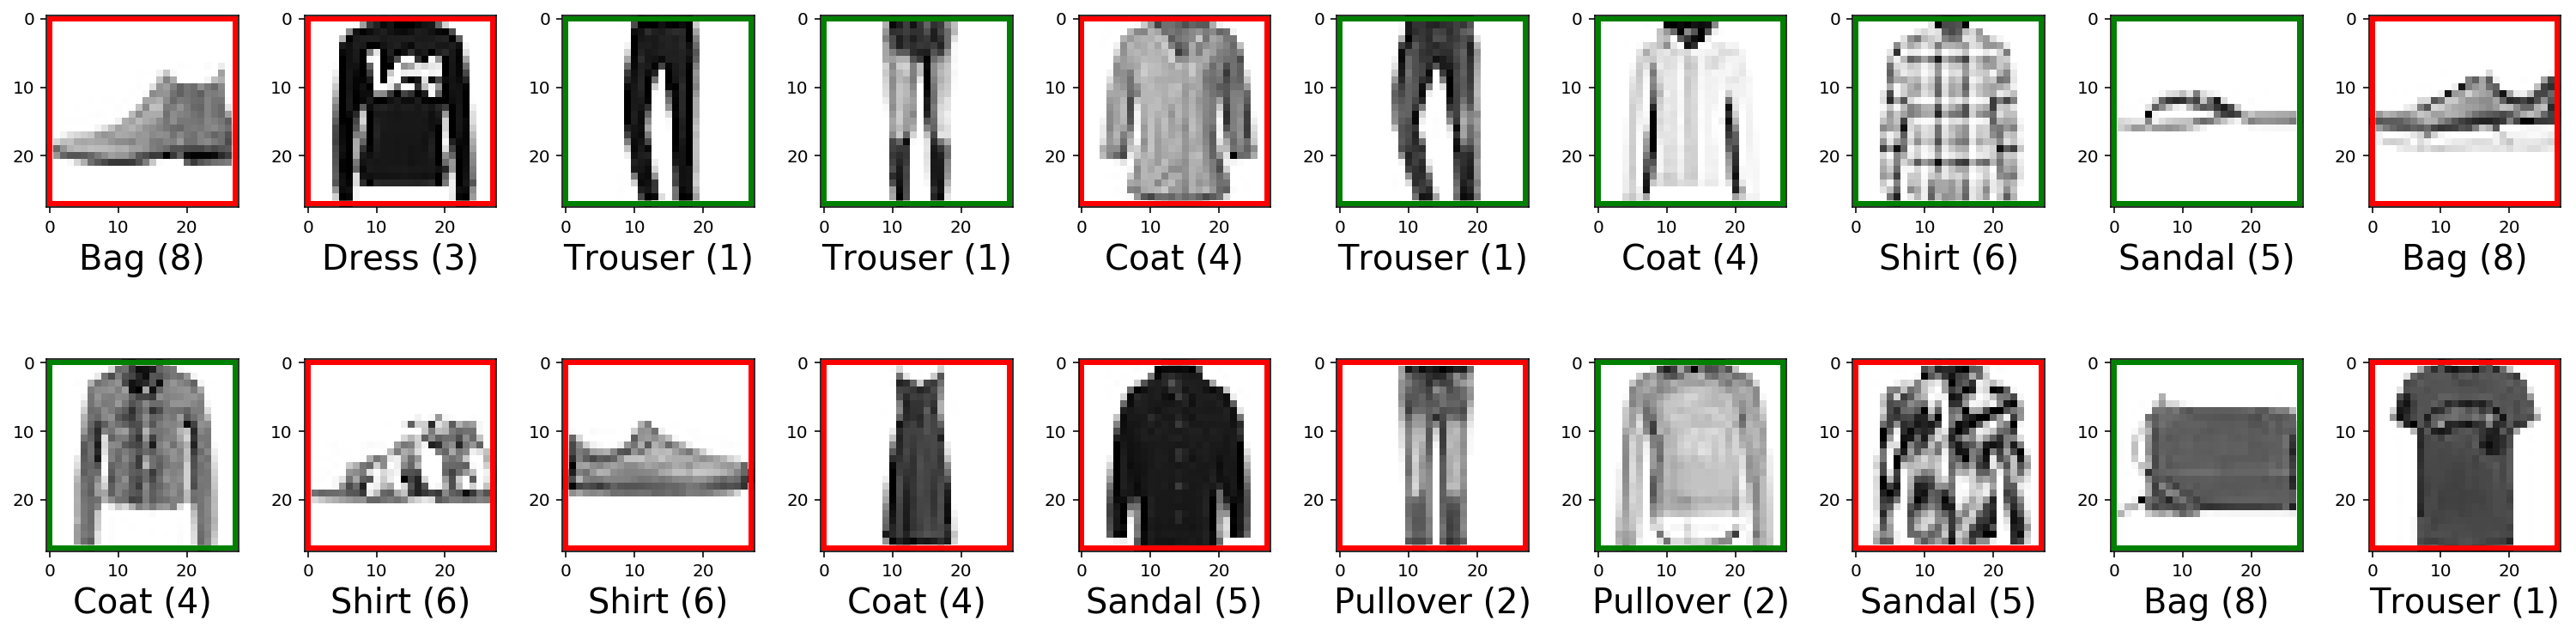

In [127]:
# optimization
num_epochs = 2
learning_rate = 0.001

# function to train on a provided dataset and network architecture
def train_and_evaluate(architecture_orig, num_epochs, learning_rate, 
                       data_train, data_test,
                       outputToLabel=outputToLabel_regression):
    # start each time from a random initialization
    architecture = architecture_orig.copy()
    architecture['W_list'] = [W.copy() for W in architecture_orig['W_list']]
    # loop over training data 
    accuracy = []
    for epoch in range(num_epochs):
        # train the network on all examples
        train(data_train, architecture, learning_rate=learning_rate)
        network_trained = lambda x: nn(x, architecture['W_list'], architecture['h_list'])
        # compute the prediction accuracy in percent
        accuracy.append(fashion_acuracy(network_trained, data_test, outputToLabel))
        print("Done epoch {}, accuracy = {}%".format(epoch, accuracy[-1]))
    fashion_evaluate(network_trained, data_test, outputToLabel)
    return accuracy

# execute the training on architecture_regression
accuracy_reg_shallow = train_and_evaluate(architecture_regression, num_epochs, learning_rate,
                                  fashion_train_regression, fashion_test_regression)

Well, about $40\%$ of the cases the correct label is predicted. It is better than random ($10\%$ average accuracy) but not very useful. 

**TODO:** Is our first implementation better than linear regression? Define a network ``architecture_linear`` without non-linearities and train it on the fashion dataset. Note, you don't have to change any of the previous functions. Just define a new dictionary with different activation functions and their Jacobians, similar to ``architecture_A`` and execute ``train_and_evaluate`` on it.

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 25.34%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 26.169999999999998%


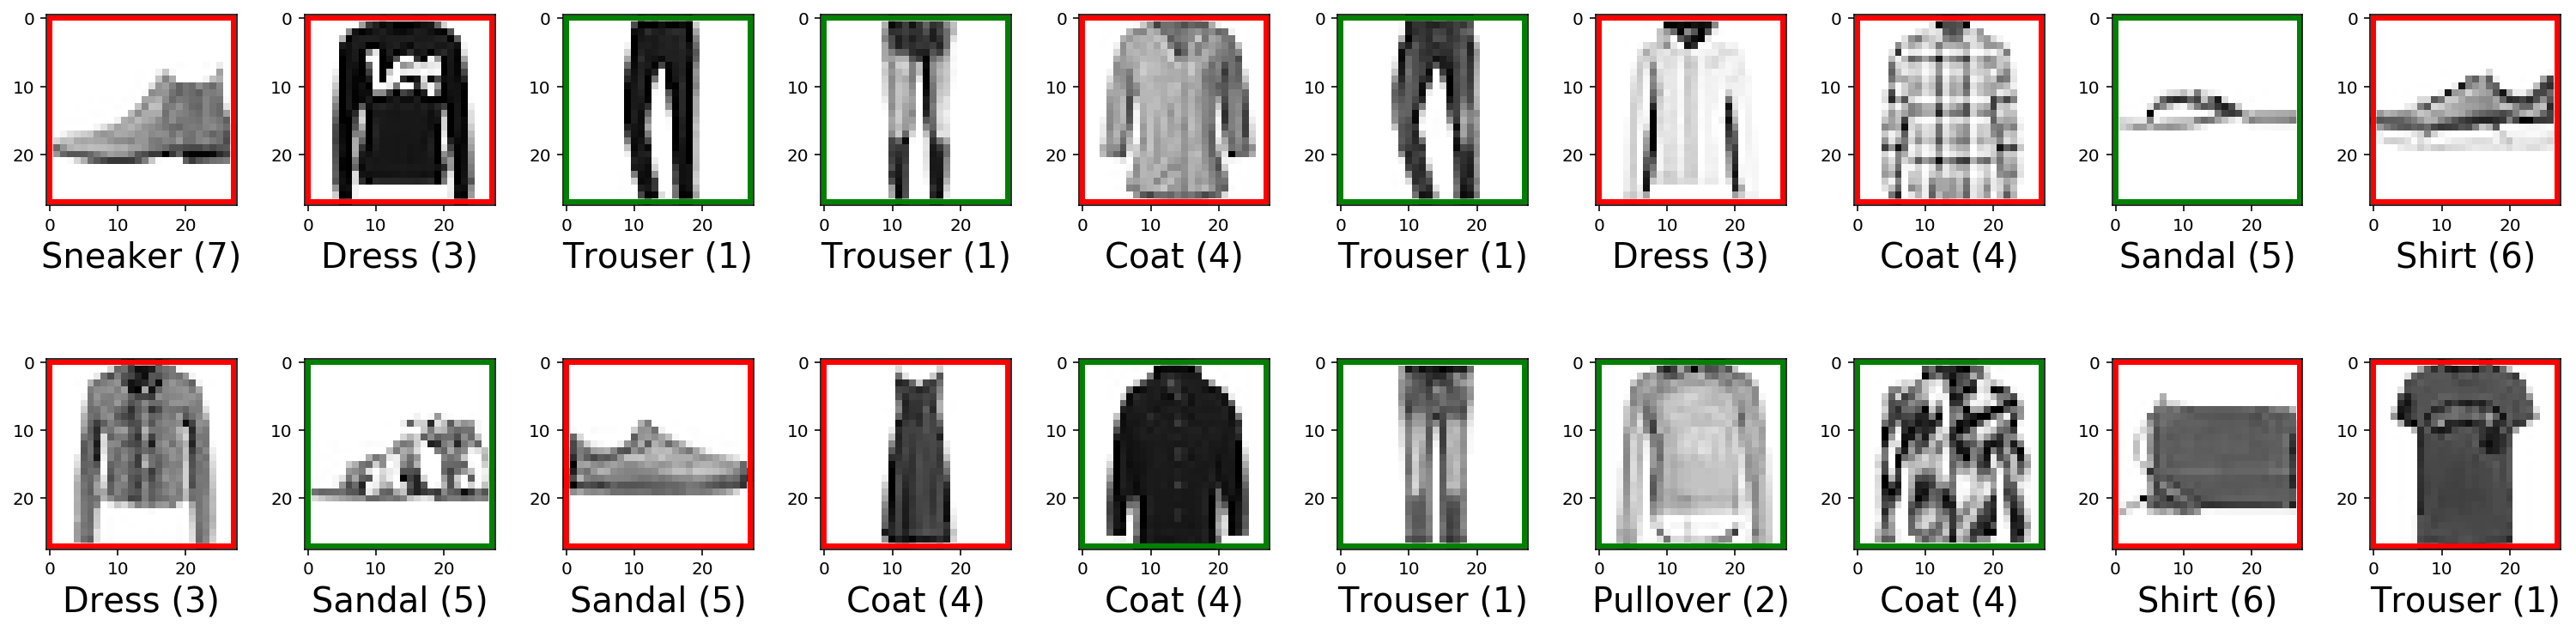

In [139]:
# solution
architecture_linear = {'W_list': initialize_network([784,50,1]),
                  'h_list': [identity,identity], # TODO
                  'back_h_list': [backprop_identity_x,backprop_identity_x]} # TODO

accuracy_reg_shallow = train_and_evaluate(architecture_linear, num_epochs, learning_rate,
                                  fashion_train_regression, fashion_test_regression)

Great, we are better than linear regression. But how can we improve further? So far we haven't thought much about how to represent the label. 

**TODO:** Explain why the label ``7:'Sneaker'`` is so often confused with ``8:'Bag'``? Note, the class label is predicted as a scalar value and it is rounded to the next integer to query the class label by ``outputToLabel_regression``.

In [129]:
# solution
print("It must be due to the rounding, as there is no classification and so 7 (sneaker) can become 8(bag)")

It must be due to the rounding, as there is no classification and so 7 (sneaker) can become 8(bag)


# 4.2 Classification (10 points)

Classification instead of regression fixes this issue. The underlying idea is to predict a probability for each class. A vector of length 10 with values between 0..1, where a value of 1 at position $k$ means that the class $k$  is present and 0 zero means that the object is not of that class. I.e. a shirt should be labeled  ``[0,0,0,0,0,0,1,0,0,0]``, a one at the 6'th position (for the 6th label) and zeroes everywhere else. 
This representation allows the network to predict uncertainty, e.g.``[0,0,0,0,0,0,0.8,0,0,0.2]`` to indicate that it is 80% sure to see a shirt, which mitigates the previously enforced ordering of labels. 

We provide a function **``fashion_prepare_classification(dataset, max_iterations)``** to construct the fashion dataset with the new classification implementation.

**TODO:** Implement the inverse function **``predictionToLabel_classification(x)``** that recovers the original scalar label ``label`` from the class vector. predicting a class will lead to inaccuracies, the predicted value will not be perfectly 0 or 1. Select the index of the class vector element with the largest value as the recovered label. The function should return an integer.

In [130]:
# solution
def predictionToLabel_classification(x):
    return np.argmax(x)

def fashion_prepare_classification(dataset, max_iterations=10000):
    images_prep = (dataset['images'][:max_iterations] - fashion_mean) / fashion_std
    labels_prep = np.zeros([max_iterations,10])
    for i in range(max_iterations):
        labels_prep[i,dataset['labels'][i]] = 1
    return {'images': images_prep,
            'labels': labels_prep}

fashion_train_classification = fashion_prepare_classification(fashion_train)
fashion_test_classification  = fashion_prepare_classification(fashion_test)

**TODO:** Define a new network and train it with the classification dataset. Name it ``architecture_classification``. Note, the output dimension of the network is no longer 1.

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 77.09%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 79.93%


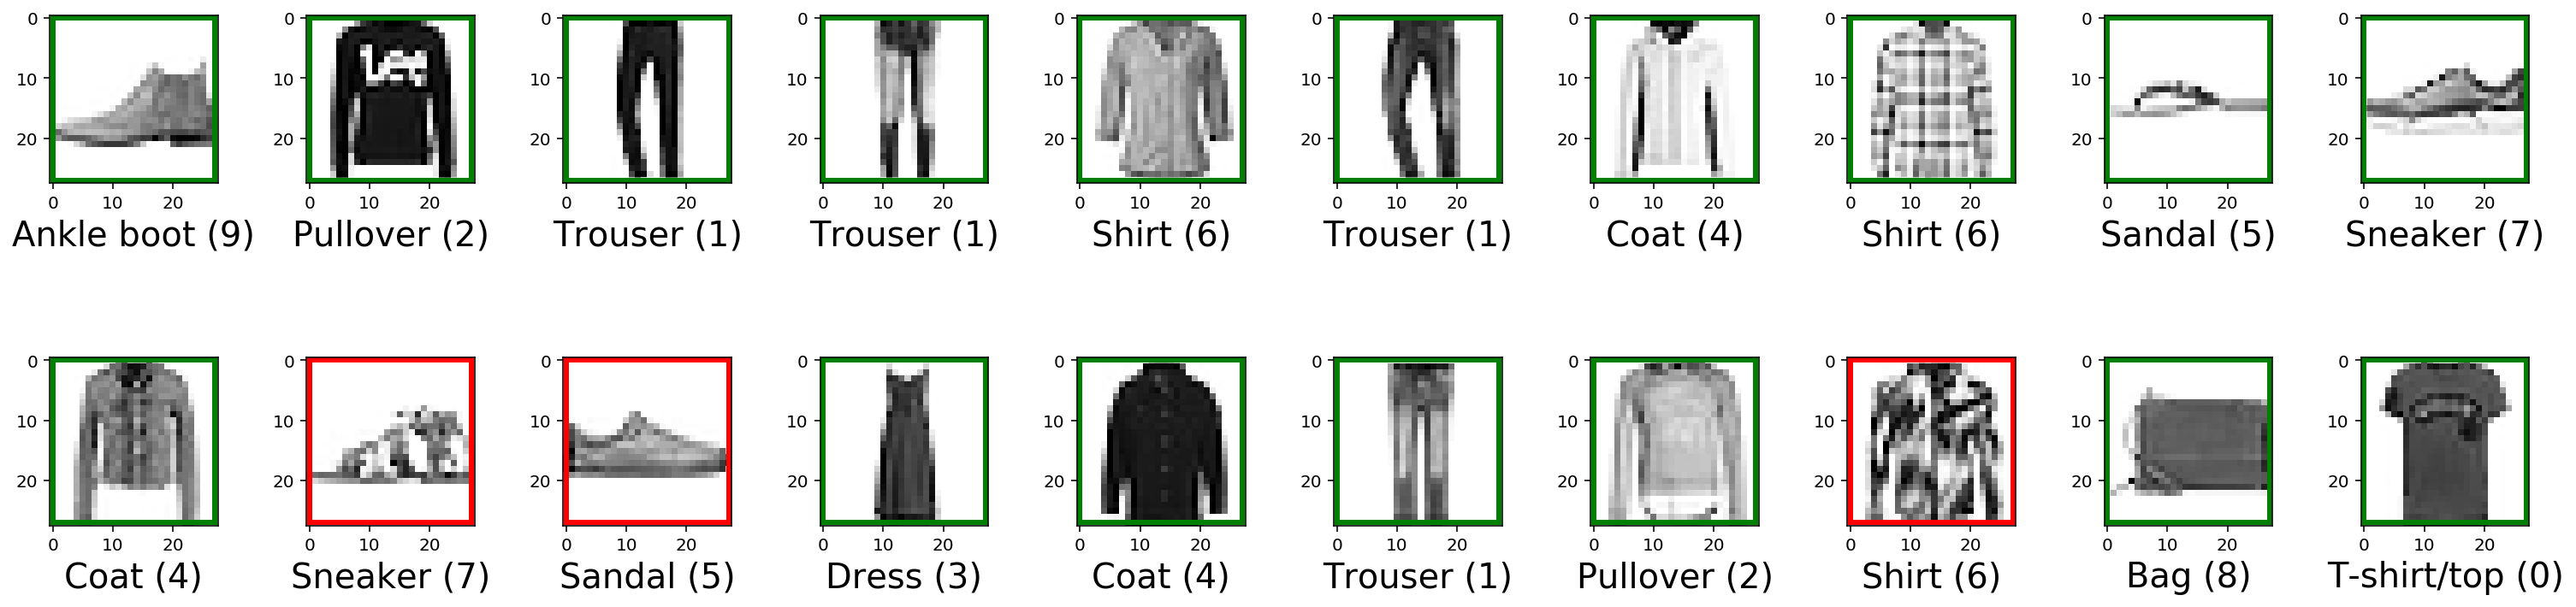

In [141]:
# solution
architecture_classification = {'W_list': initialize_network([784,50,10]), # TODO
                  'h_list': [relu, identity],
                  'back_h_list': [backprop_relu_x, backprop_identity_x]}

accuracy_class_shallow = train_and_evaluate(architecture_classification, num_epochs, learning_rate,
                   fashion_train_classification, fashion_test_classification,
                   outputToLabel=predictionToLabel_classification)

Well, that result looks promising, about 80% accuracy!

**TODO** Define a network with more neurons in the hidden layer or more hidden layers that performs even better. Improvements of at least 2% are possible. Name it ``architecture_wide``. What number of neurons is a good choice?

### 100 Neurons

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 78.59%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 81.22%


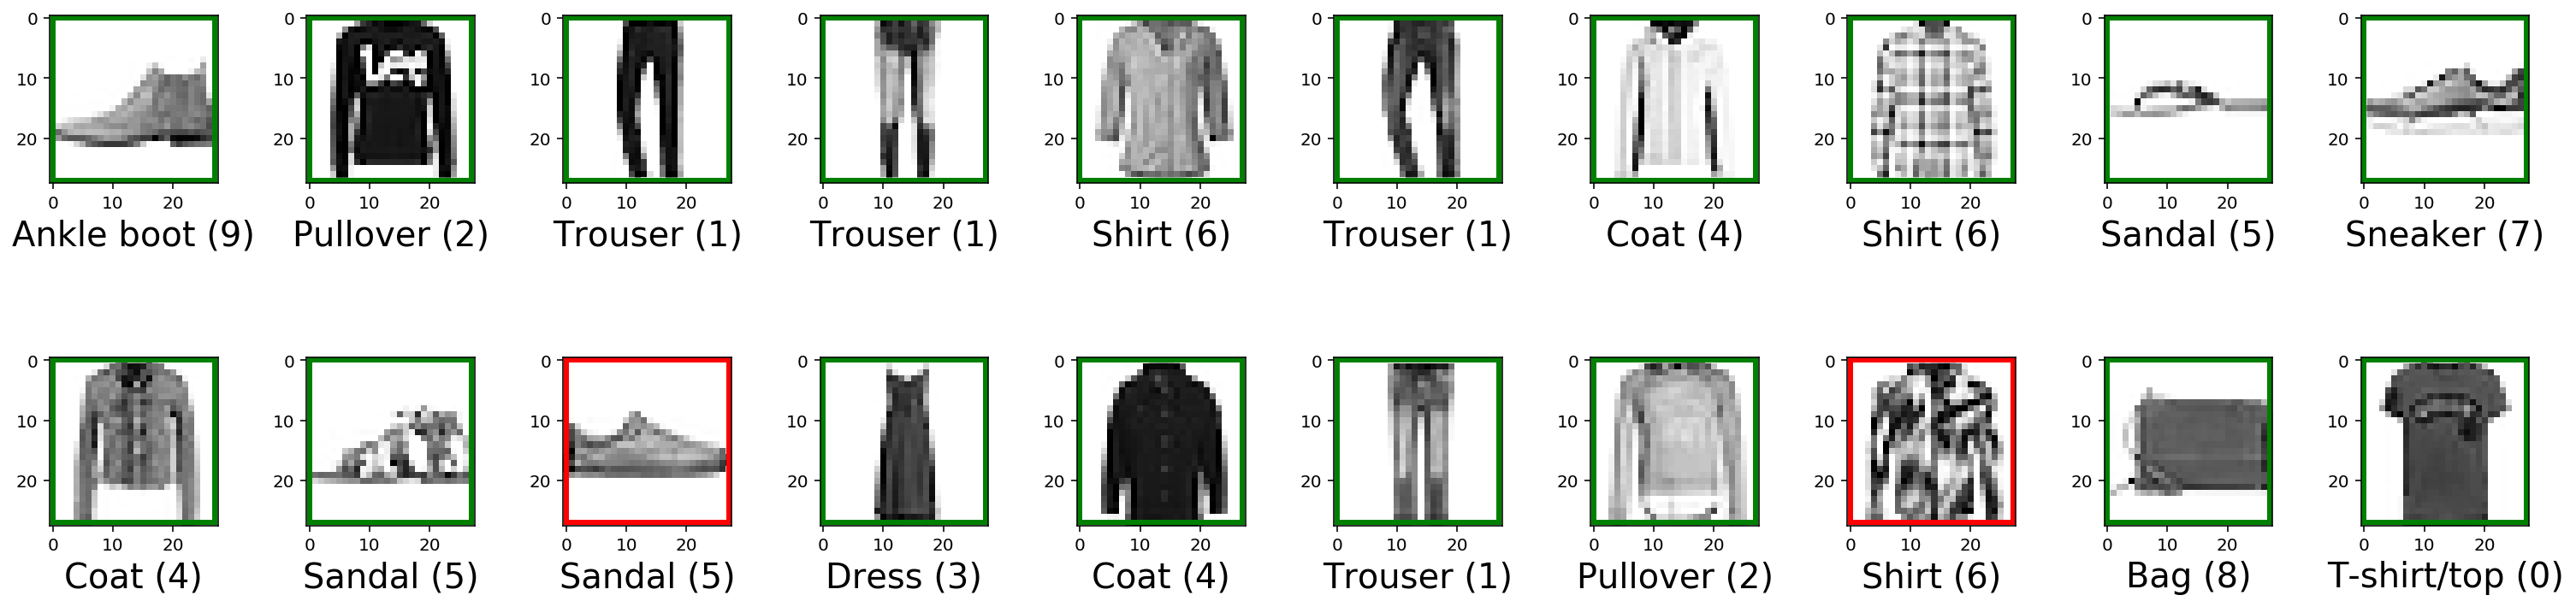

In [132]:
# solution
architecture_wide = {'W_list': initialize_network([784, 100, 10]), # TODO
                  'h_list': [relu, identity], # TODO
                  'back_h_list': [backprop_relu_x, backprop_identity_x]} # TODO

accuracy_class_wide = train_and_evaluate(architecture_wide, num_epochs, learning_rate,
                   fashion_train_classification, fashion_test_classification,
                   outputToLabel=predictionToLabel_classification)

### 300 Neurons

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 80.9%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 82.97%


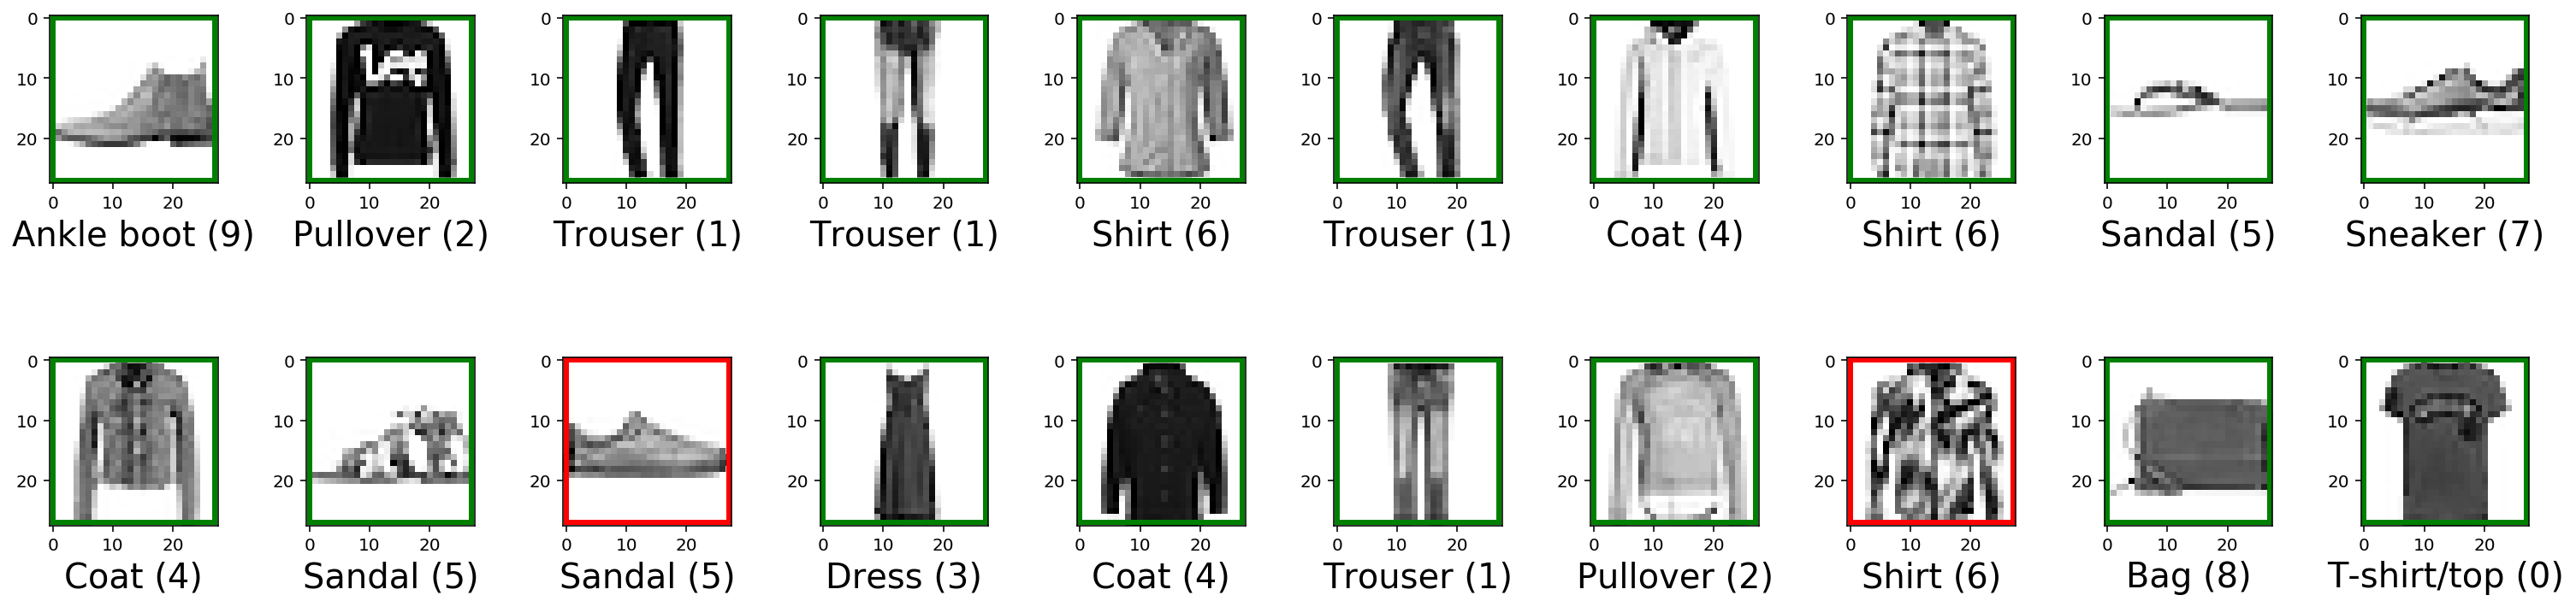

In [133]:
# solution
architecture_wide = {'W_list': initialize_network([784, 300, 10]), # TODO
                  'h_list': [relu, identity], # TODO
                  'back_h_list': [backprop_relu_x, backprop_identity_x]} # TODO

accuracy_class_wide = train_and_evaluate(architecture_wide, num_epochs, learning_rate,
                   fashion_train_classification, fashion_test_classification,
                   outputToLabel=predictionToLabel_classification)

### 1000 Neurons

Finished training iteration 9900, learning rate = 0.001
Done epoch 0, accuracy = 82.52000000000001%
Finished training iteration 9900, learning rate = 0.001
Done epoch 1, accuracy = 83.78999999999999%


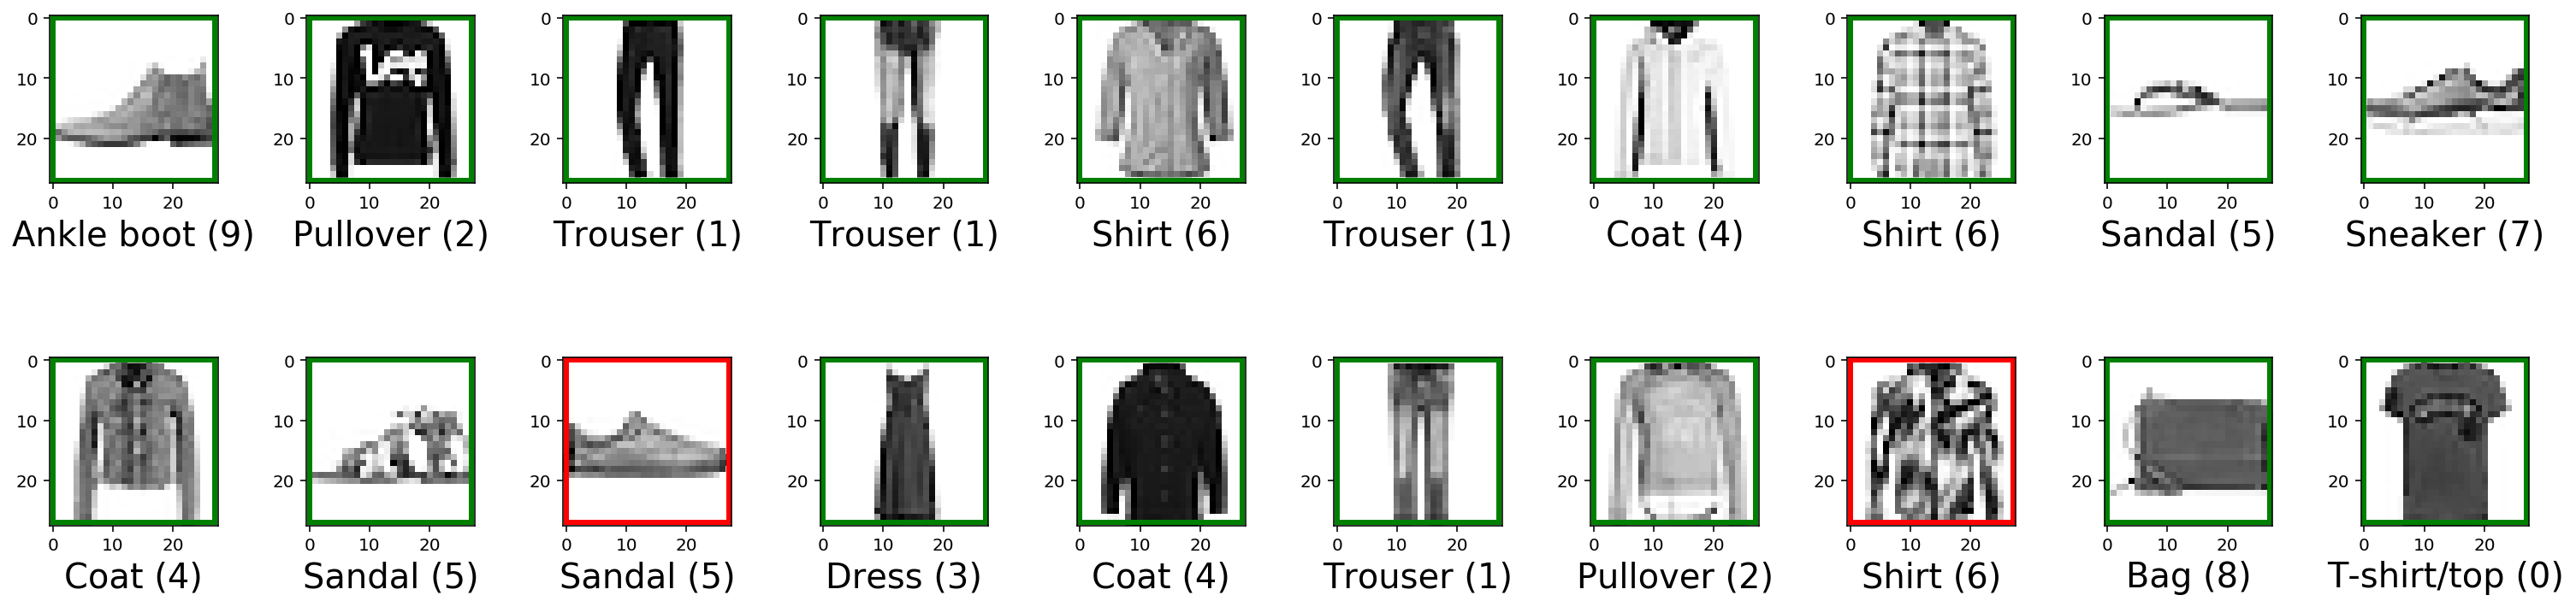

In [135]:
# solution
architecture_wide = {'W_list': initialize_network([784, 1000, 10]), # TODO
                  'h_list': [relu, identity], # TODO
                  'back_h_list': [backprop_relu_x, backprop_identity_x]} # TODO

accuracy_class_wide = train_and_evaluate(architecture_wide, num_epochs, learning_rate,
                   fashion_train_classification, fashion_test_classification,
                   outputToLabel=predictionToLabel_classification)

### Conclusion
The more neurons we have, the more precise it gets, but it also takes a lot more time. The choice between
result and time can be made, but here 300 neurons seems like a good compromise !